Clone Repository with Data

In [1]:
!git clone https://github.com/jasonjabbour/arch-gym-proxy-models.git

Cloning into 'arch-gym-proxy-models'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15 (delta 1), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [2]:
!cd arch-gym-proxy-models/
%cd arch-gym-proxy-models/

/content/arch-gym-proxy-models


Import Dependencies

In [3]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Declare Global Variables

In [4]:
DATASET_FILENAME = 'data.csv'
DATA_DIRECTORY = 'data'

Read Dataset

In [5]:
dataset_path = os.path.join(DATA_DIRECTORY, DATASET_FILENAME)
df = pd.read_csv(dataset_path)

In [6]:
df.head()

,Reward,Arbiter,MaxActiveTransactions,PagePolicy,RefreshMaxPostponed,RefreshMaxPulledin,RefreshPolicy,RequestBufferSize,RespQueue,Scheduler,SchedulerBuffer,Energy,Power,Latency
0,14.294449,Fifo,4,OpenAdaptive,4,4,AllBank,4,Reorder,FrFcfs,Bankwise,0.192833,1.76718,0.109119
1,2.357000,Reorder,16,Closed,4,5,NoRefresh,2,Reorder,FrFcfsGrp,ReadWrite,0.358195,1.21885,0.293860
2,1.950238,Simple,1,Open,1,8,AllBank,8,Fifo,FrFcfsGrp,Bankwise,0.169617,2.54155,0.066738
3,0.925141,Reorder,128,ClosedAdaptive,7,6,AllBank,2,Fifo,FrFcfsGrp,Bankwise,0.179676,2.08185,0.000086
4,7.141077,Fifo,1,Closed,7,4,NoRefresh,3,Reorder,FrFcfs,Bankwise,0.411641,1.04782,0.392830


In [7]:
df.describe(include='all')

,Reward,Arbiter,MaxActiveTransactions,PagePolicy,RefreshMaxPostponed,RefreshMaxPulledin,RefreshPolicy,RequestBufferSize,RespQueue,Scheduler,SchedulerBuffer,Energy,Power,Latency
count,109032.000000,109032,109032.000000,109032,109032.000000,109032.000000,109032,109032.000000,109032,109032,109032,109032.000000,109032.000000,1.090320e+05
unique,NaN,3,NaN,4,NaN,NaN,2,NaN,2,3,3,NaN,NaN,NaN
top,NaN,Simple,NaN,ClosedAdaptive,NaN,NaN,NoRefresh,NaN,Reorder,FrFcfsGrp,Bankwise,NaN,NaN,NaN
freq,NaN,38732,NaN,29194,NaN,NaN,57309,NaN,58114,38560,38132,NaN,NaN,NaN
mean,6.236542,NaN,34.764647,NaN,4.663108,4.688981,NaN,4.448043,NaN,NaN,NaN,0.250282,1.740112,1.209251e-01
std,21.259956,NaN,42.367242,NaN,2.253437,2.227197,NaN,2.315384,NaN,NaN,NaN,0.087394,0.531943,1.214228e-01
min,0.634379,NaN,1.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,0.167405,0.966800,6.800000e-08
25%,1.998473,NaN,2.000000,NaN,3.000000,3.000000,NaN,2.000000,NaN,NaN,NaN,0.173755,1.281040,2.979950e-04
50%,2.816211,NaN,16.000000,NaN,5.000000,5.000000,NaN,5.000000,NaN,NaN,NaN,0.194026,1.700540,7.603625e-02
75%,4.306913,NaN,64.000000,NaN,7.000000,7.000000,NaN,6.000000,NaN,NaN,NaN,0.344250,2.293990,2.520725e-01


In [8]:
df.shape

(109032, 14)

# EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109032 entries, 0 to 109031
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Reward                 109032 non-null  float64
 1   Arbiter                109032 non-null  object 
 2   MaxActiveTransactions  109032 non-null  int64  
 3   PagePolicy             109032 non-null  object 
 4   RefreshMaxPostponed    109032 non-null  int64  
 5   RefreshMaxPulledin     109032 non-null  int64  
 6   RefreshPolicy          109032 non-null  object 
 7   RequestBufferSize      109032 non-null  int64  
 8   RespQueue              109032 non-null  object 
 9   Scheduler              109032 non-null  object 
 10  SchedulerBuffer        109032 non-null  object 
 11  Energy                 109032 non-null  float64
 12  Power                  109032 non-null  float64
 13  Latency                109032 non-null  float64
dtypes: float64(4), int64(4), object(6)
m

no null values in dataset

In [10]:
print(df['Arbiter'].unique())
print(df['PagePolicy'].unique())
print(df['RefreshPolicy'].unique())
print(df['RespQueue'].unique())
print(df['Scheduler'].unique())
print(df['SchedulerBuffer'].unique())
print(df['MaxActiveTransactions'].unique())
print(df['RefreshMaxPostponed'].unique())
print(df['RefreshMaxPulledin'].unique())
print(df['RequestBufferSize'].unique())

['Fifo' 'Reorder' 'Simple']
['OpenAdaptive' 'Closed' 'Open' 'ClosedAdaptive']
['AllBank' 'NoRefresh']
['Reorder' 'Fifo']
['FrFcfs' 'FrFcfsGrp' 'Fifo']
['Bankwise' 'ReadWrite' 'Shared']
[  4  16   1 128   2   8  64  32]
[4 1 7 6 2 3 5 8]
[4 5 8 6 7 3 1 2]
[4 2 8 3 6 1 7 5]


Even though, MaxActiveTransactions, RefreshMaxPostponed, RefreshMaxPulledin, RequestBufferSize are integer values, the order still matters. They have inherent ordering. I will keep these variables as numberical variables instead of converting them to categorical variables

In [11]:
# Get column names
col_names_raw = df.columns

In [12]:
# Separate Categorical Variable from Numerical Variabels
categorical_variables = ['Arbiter','PagePolicy','RefreshPolicy', 'RespQueue', 'Scheduler','SchedulerBuffer']
numerical_variables = [v for v in col_names_raw if v not in categorical_variables]

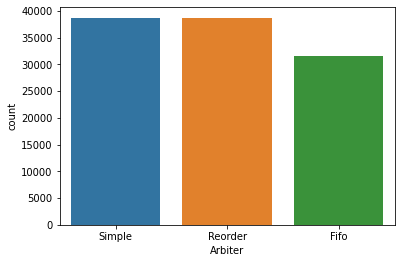

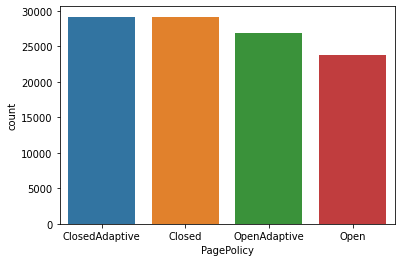

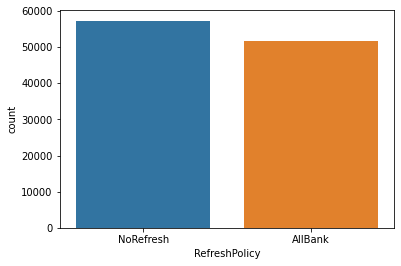

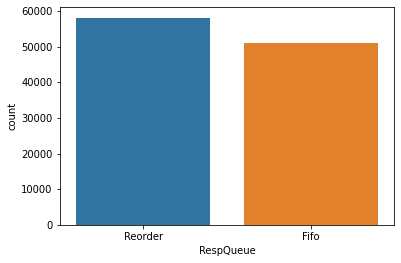

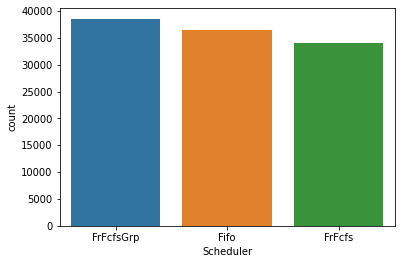

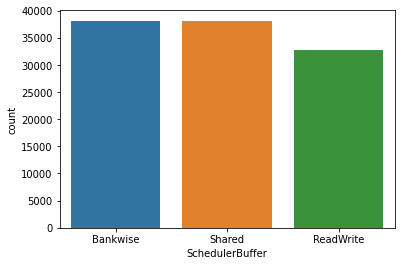

In [13]:
# Count Distribution of Each Categorical Variable
for c in categorical_variables:
  plt.figure()
  ax = sns.countplot(data=df, x=c, order=df[c].value_counts().index)
  plt.show()

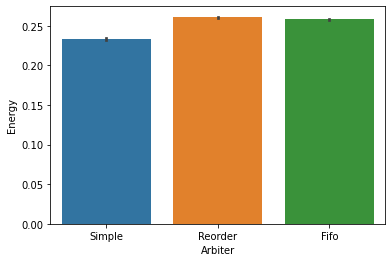

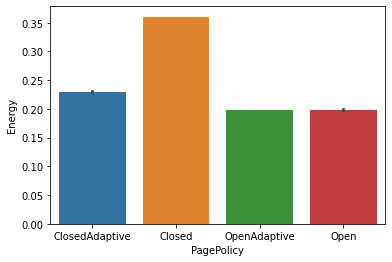

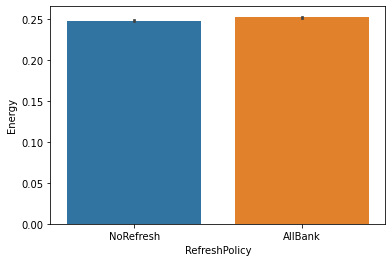

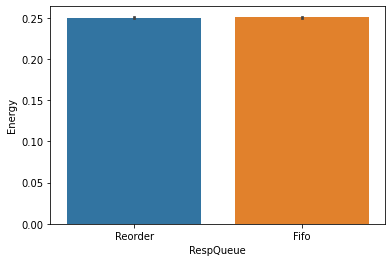

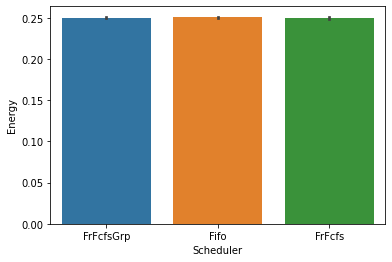

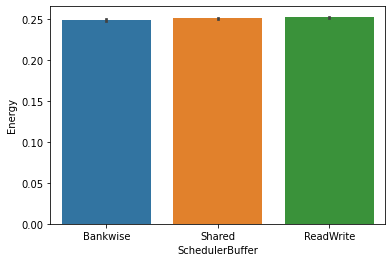

In [14]:
# Distribution of Categorical Variables with Energy 
for c in categorical_variables:
  plt.figure()
  ax = sns.barplot(data=df, x=c, y=df['Energy'], order=df[c].value_counts().index)
  plt.show()

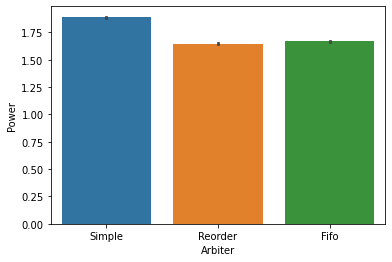

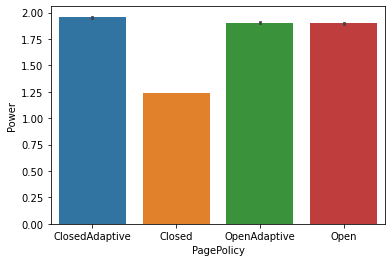

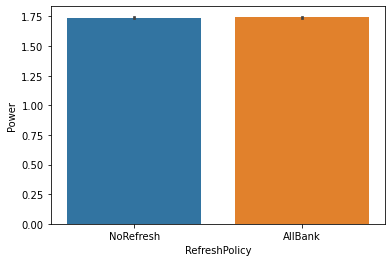

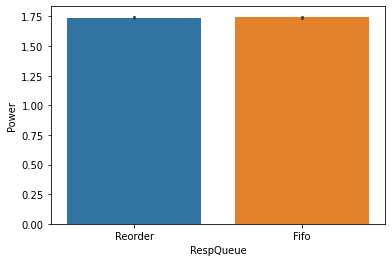

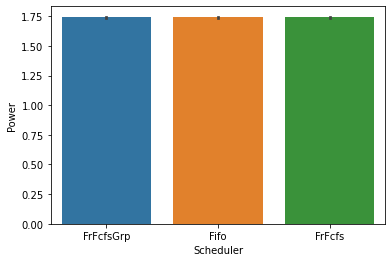

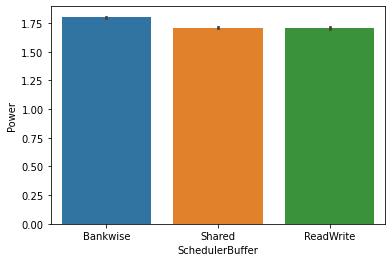

In [15]:
# Distribution of Categorical Variables with Power 
for c in categorical_variables:
  plt.figure()
  ax = sns.barplot(data=df, x=c, y=df['Power'], order=df[c].value_counts().index)
  plt.show()

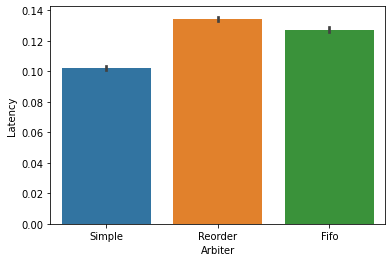

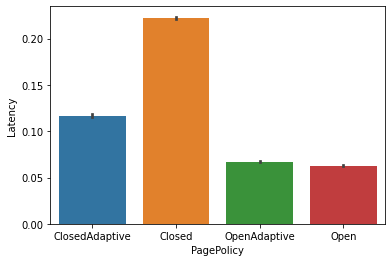

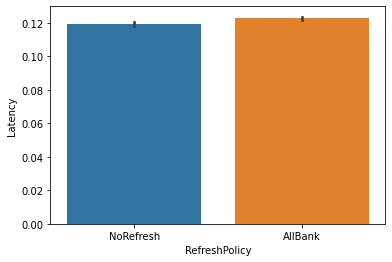

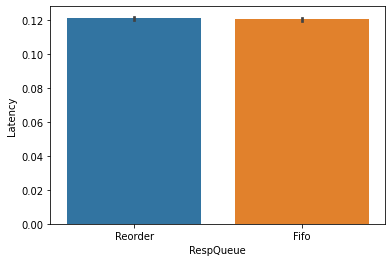

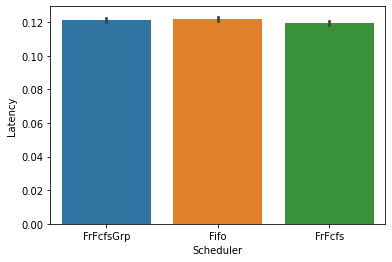

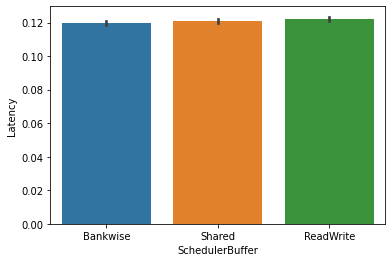

In [16]:
# Distribution of Categorical Variables with Latency 
for c in categorical_variables:
  plt.figure()
  ax = sns.barplot(data=df, x=c, y=df['Latency'], order=df[c].value_counts().index)
  plt.show()

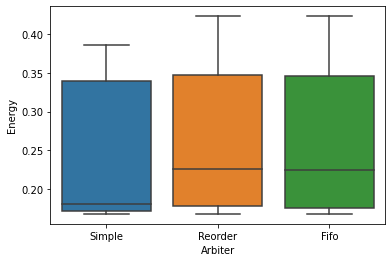

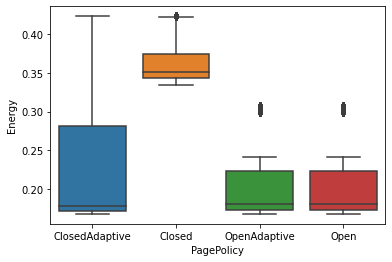

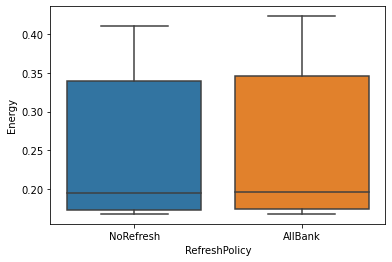

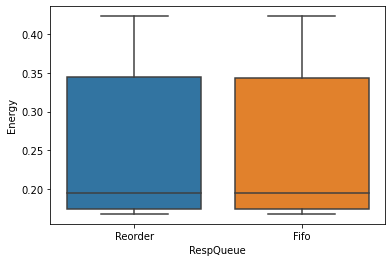

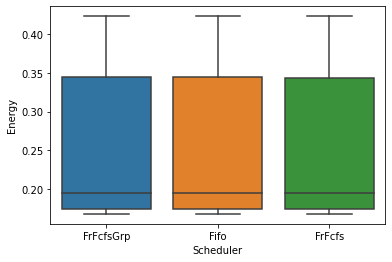

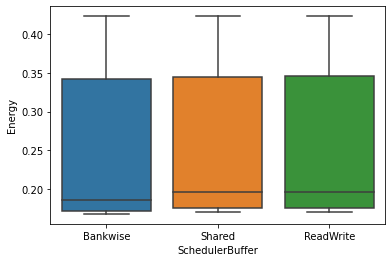

In [17]:
# Distribution of Categorical Variables with Energy 
for c in categorical_variables:
  plt.figure()
  ax = sns.boxplot(data=df, x=c, y=df['Energy'], order=df[c].value_counts().index)
  plt.show()


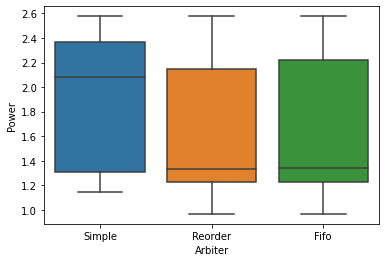

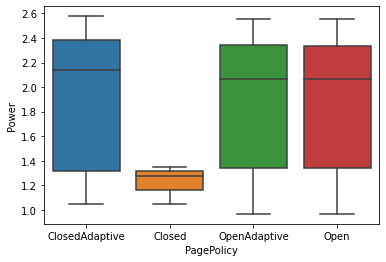

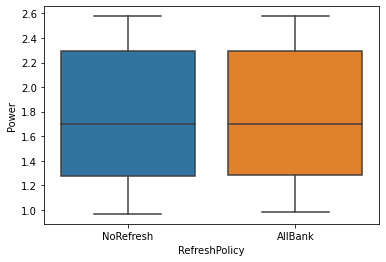

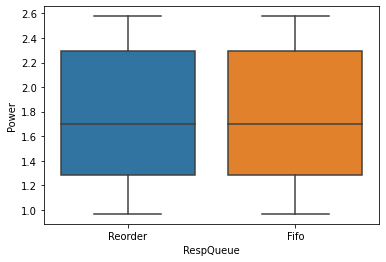

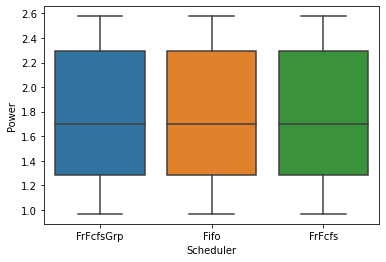

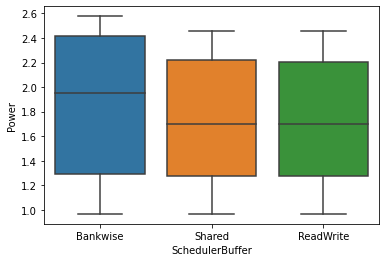

In [18]:
# Distribution of Categorical Variables with Power 
for c in categorical_variables:
  plt.figure()
  ax = sns.boxplot(data=df, x=c, y=df['Power'], order=df[c].value_counts().index)
  plt.show()

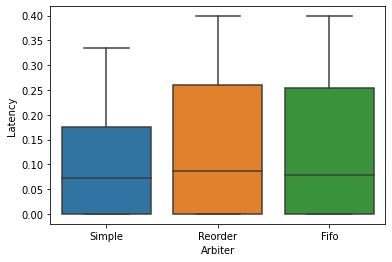

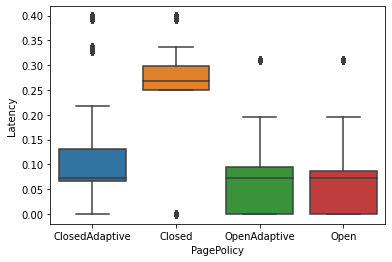

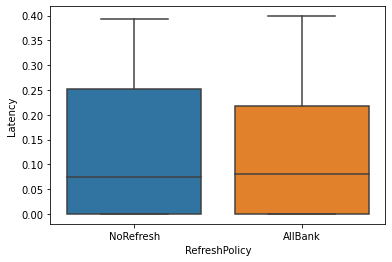

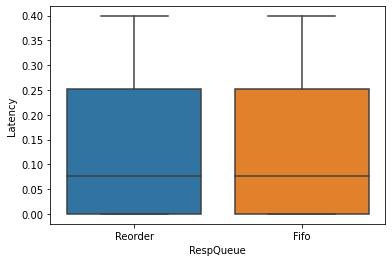

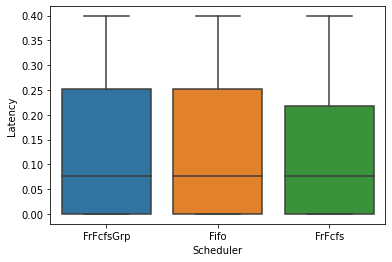

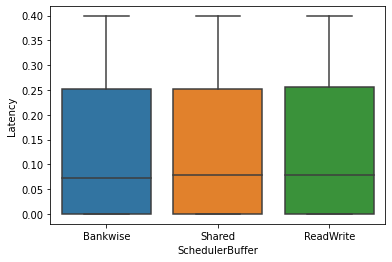

In [19]:
# Distribution of Categorical Variables with Latency 
for c in categorical_variables:
  plt.figure()
  ax = sns.boxplot(data=df, x=c, y=df['Latency'], order=df[c].value_counts().index)
  plt.show()

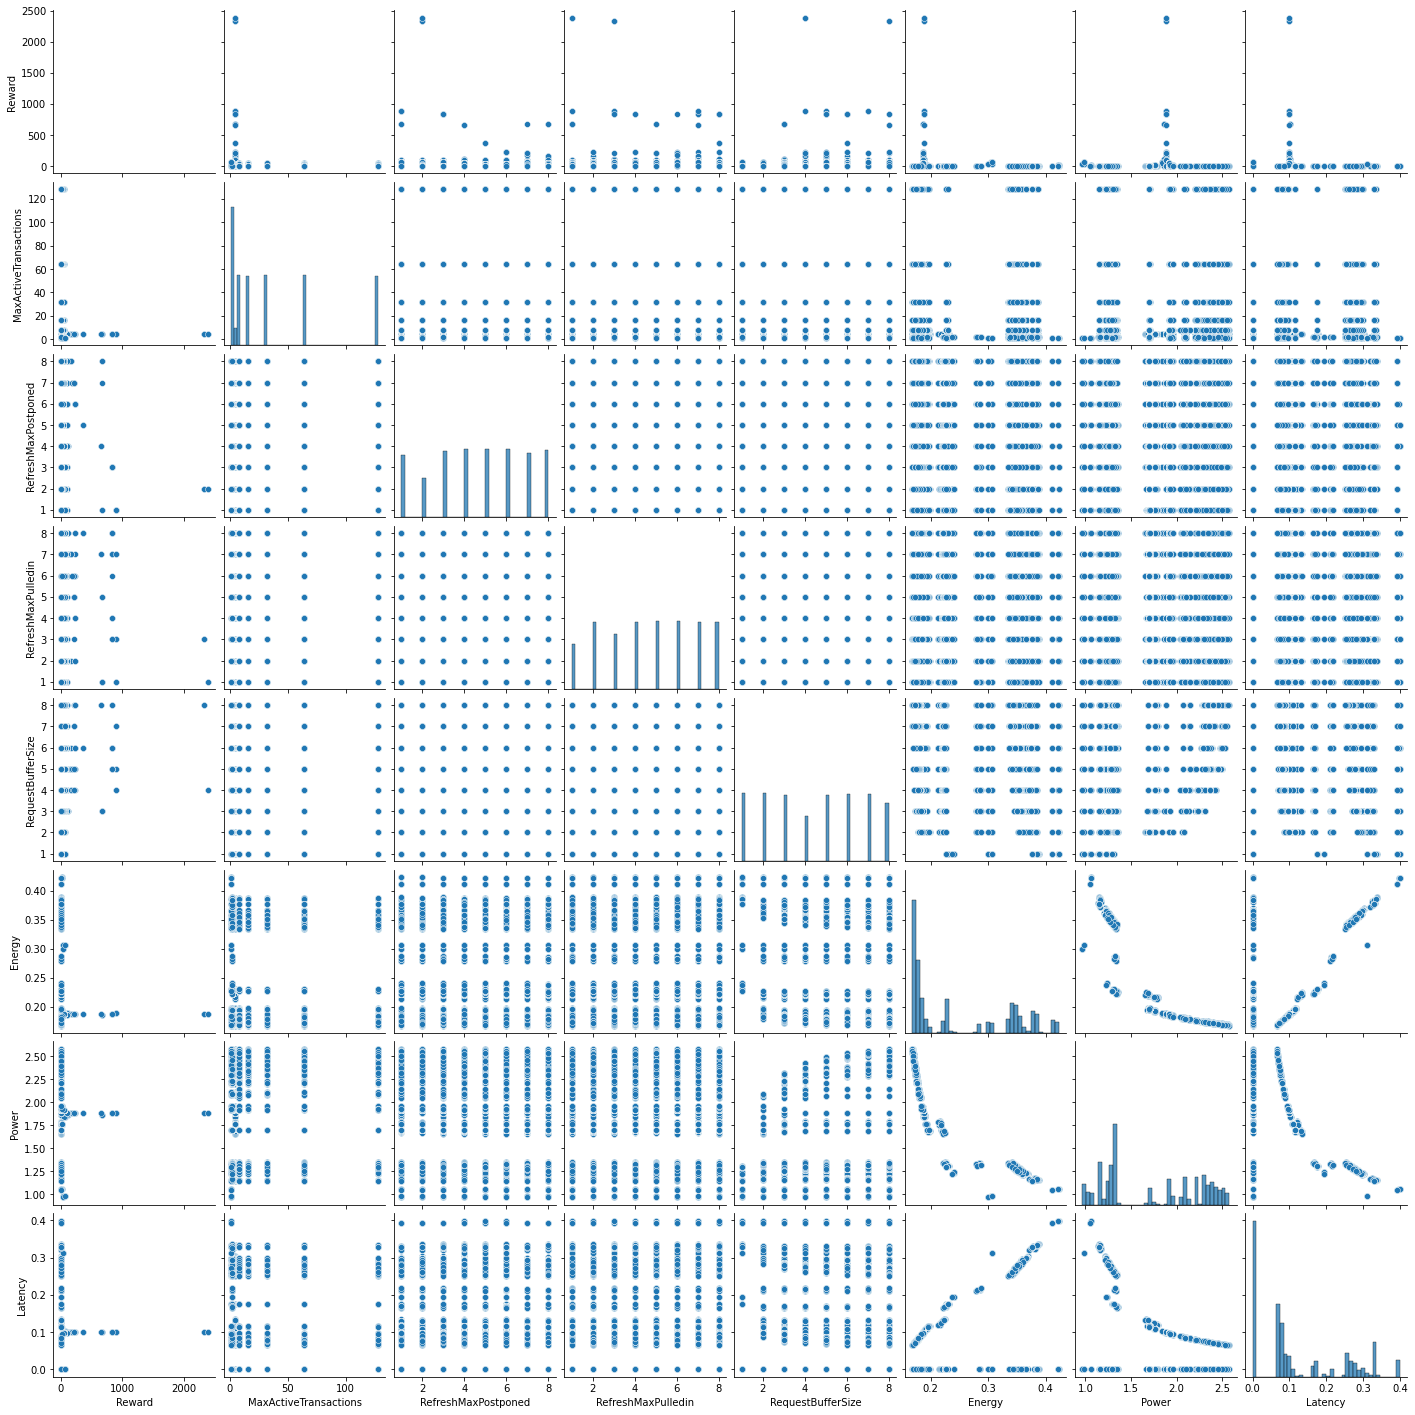

In [20]:
# Pairplot
sns.pairplot(df)

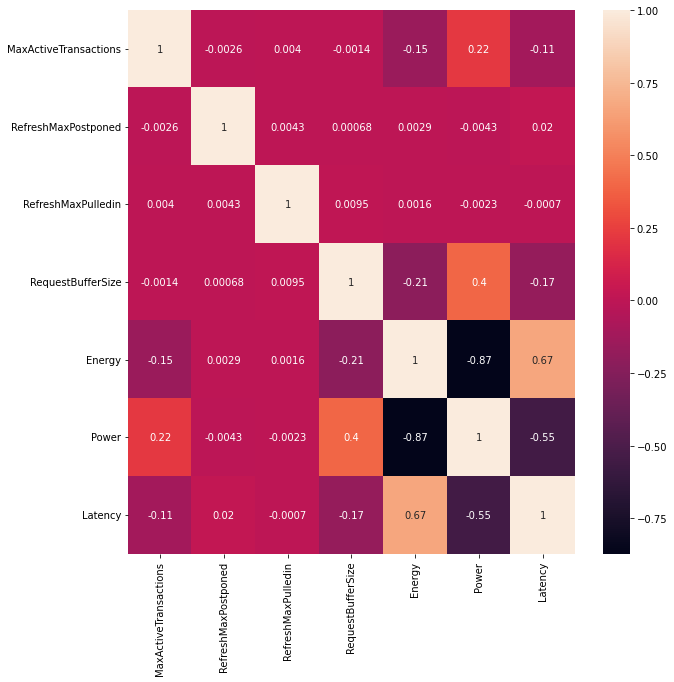

In [21]:
# Remove Reward
heatmap_df = df.drop(columns=['Reward'])
# Headmap
plt.figure(figsize=(10,10))
sns.heatmap(df[numerical_variables[1:]].corr(), annot=True)
plt.show()

# Clean Data

In [22]:
# Remove Reward
df = df.drop(columns=['Reward'])
numerical_variables = numerical_variables[1:]

In [23]:
# Check for missing values
df.isnull().sum()

Arbiter                  0
MaxActiveTransactions    0
PagePolicy               0
RefreshMaxPostponed      0
RefreshMaxPulledin       0
RefreshPolicy            0
RequestBufferSize        0
RespQueue                0
Scheduler                0
SchedulerBuffer          0
Energy                   0
Power                    0
Latency                  0
dtype: int64

no missing values

# Data Engineering

In [24]:
dummy_variables = pd.get_dummies(df[categorical_variables])
dummy_variables

,Arbiter_Fifo,Arbiter_Reorder,Arbiter_Simple,PagePolicy_Closed,PagePolicy_ClosedAdaptive,PagePolicy_Open,PagePolicy_OpenAdaptive,RefreshPolicy_AllBank,RefreshPolicy_NoRefresh,RespQueue_Fifo,RespQueue_Reorder,Scheduler_Fifo,Scheduler_FrFcfs,Scheduler_FrFcfsGrp,SchedulerBuffer_Bankwise,SchedulerBuffer_ReadWrite,SchedulerBuffer_Shared
0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
1,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0
2,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0
3,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0
4,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109027,0,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,0
109028,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0
109029,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1
109030,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1


# Model Building


In [25]:
TRAIN_SPLIT_SIZE = .8

In [26]:
# Targets
y = df[['Energy', 'Power', 'Latency']]
# Numerical Features 
X = df[numerical_variables[:4]] 
# Add Categorical Encoded Features
X = X.join(dummy_variables)

In [27]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=TRAIN_SPLIT_SIZE, random_state=100)
X_train.head()

,MaxActiveTransactions,RefreshMaxPostponed,RefreshMaxPulledin,RequestBufferSize,Arbiter_Fifo,Arbiter_Reorder,Arbiter_Simple,PagePolicy_Closed,PagePolicy_ClosedAdaptive,PagePolicy_Open,...,RefreshPolicy_AllBank,RefreshPolicy_NoRefresh,RespQueue_Fifo,RespQueue_Reorder,Scheduler_Fifo,Scheduler_FrFcfs,Scheduler_FrFcfsGrp,SchedulerBuffer_Bankwise,SchedulerBuffer_ReadWrite,SchedulerBuffer_Shared
95858,2,7,7,7,0,0,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
68623,32,5,7,1,0,0,1,0,1,0,...,0,1,1,0,1,0,0,0,0,1
36199,1,8,3,5,0,0,1,0,1,0,...,0,1,0,1,1,0,0,0,0,1
91723,64,8,3,8,1,0,0,0,1,0,...,0,1,0,1,1,0,0,1,0,0
15176,64,8,2,1,0,0,1,0,0,1,...,0,1,0,1,0,1,0,0,0,1


## Linear Regression Model

In [28]:
# Train Baseline Linear Regression Model
linear = LinearRegression()
linear.fit(X_train, y_train)

y_train_pred_linear = linear.predict(X_train)
y_test_pred_linear = linear.predict(X_test)

In [29]:
# Score Linear Regression Model
print(f'Mean Squared Error for Train: {round(mse(y_train, y_train_pred_linear),5)}')
print(f'Mean Squared Error for Test: {round(mse(y_test, y_test_pred_linear),5)}')

Mean Squared Error for Train: 0.04397
Mean Squared Error for Test: 0.04391


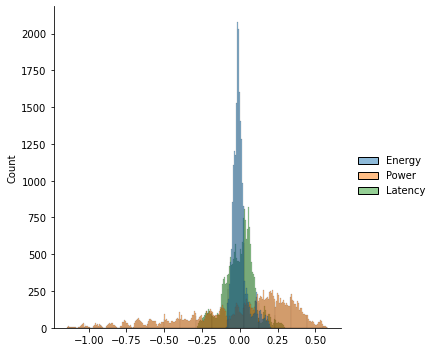

In [30]:
sns.displot(y_test - y_test_pred_linear)

Visualize Linear Regression Results

In [31]:
# Make Predictions into a Dataframe
y_test_pred_linear_df = pd.DataFrame(y_test_pred_linear, columns=['Energy Predicted', 'Power Predicted', 'Latency Predicted'])

In [32]:
# Reset Index of Test Set
y_test_index_reset = y_test.reset_index(drop=True)
# Place test set and predicted set in the same dataset
linear_evaluation_df = y_test_pred_linear_df.join(y_test_index_reset)

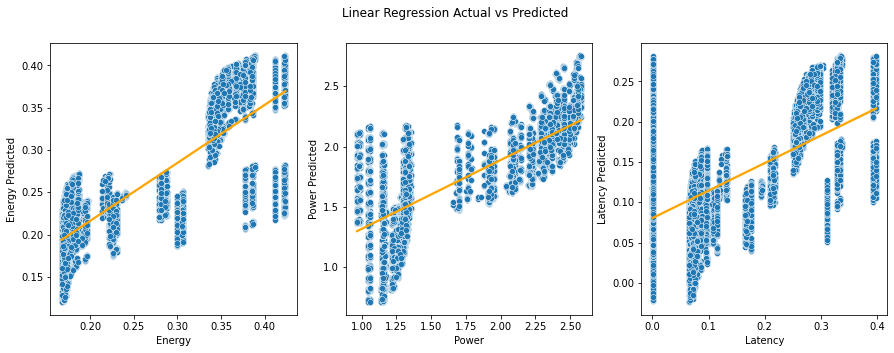

In [33]:
# Linear Regression Graph

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle("Linear Regression Actual vs Predicted")
plt.subplot(1,3,1)
ax0 = sns.scatterplot(x='Energy', y='Energy Predicted', data=linear_evaluation_df)
sns.regplot(x='Energy', y='Energy Predicted',
            scatter=False, data=linear_evaluation_df,
            ax=ax0, color="orange")

plt.subplot(1,3,2)
ax1 = sns.scatterplot(x='Power', y='Power Predicted', data=linear_evaluation_df)
sns.regplot(x='Power', y='Power Predicted',
            scatter=False, data=linear_evaluation_df,
            ax=ax1, color="orange")

plt.subplot(1,3,3)
ax2 = sns.scatterplot(x='Latency', y='Latency Predicted', data=linear_evaluation_df)
sns.regplot(x='Latency', y='Latency Predicted',
            scatter=False, data=linear_evaluation_df,
            ax=ax2, color="orange")

## Random Forest Model

In [34]:
# Random Forst Model

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1200, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [i for i in range(2,11,2)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]


# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [20, 104, 188, 272, 357, 441, 525, 610, 694, 778, 862, 947, 1031, 1115, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


Hyperparameter search (This block takes a long time to execute. Values have been loaded in the next block)

In [ ]:
# Cross Validation to find best parameters

rf= RandomForestRegressor(n_estimators=100,criterion='mse', 
                                 max_depth=10, min_samples_split=10,
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True, n_jobs=-1, random_state=100, verbose=0)


grid_rf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,scoring = 'neg_mean_squared_error',random_state =100)

grid_rf.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(criterion='mse',
                                                   max_depth=10,
                                                   min_samples_split=10,
                                                   n_jobs=-1,
                                                   random_state=100),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [20, 104, 188, 272, 357,
                                                         441, 525, 610, 694,
                                                         778, 862, 947, 1031,
       

In [35]:
# Best Parameters
grid_rf.best_params_ 

NameError: ignored

In [ ]:
#Model with Best parameters

rf= RandomForestRegressor(n_estimators=610,criterion='mse', 
                                 max_depth=8, min_samples_split=5,
                                 min_samples_leaf=5, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True,n_jobs=-1, random_state=100, verbose=0)
rf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', max_depth=8, min_samples_leaf=5,
                      min_samples_split=5, n_estimators=610, n_jobs=-1,
                      random_state=100)

Evaluate Random Forest Model

In [ ]:
# Prediction
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

#Scoring
print('Mean Squared Error for train : {}'.format(round(mse(y_train,y_train_pred_rf),5)))
print('Mean Squared Error for test : {}'.format(round(mse(y_test,y_test_pred_rf),5)))


Mean Squared Error for train : 0.00123
Mean Squared Error for test : 0.00129


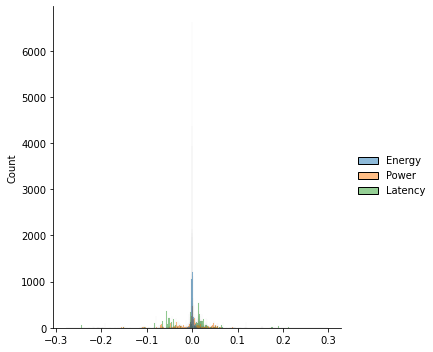

In [ ]:
#Checking error distribution
sns.displot(y_test-y_test_pred_rf)

Visualize Random Forest Regression Results

In [ ]:
# Make Predictions into a Dataframe
y_test_pred_rf_df = pd.DataFrame(y_test_pred_rf, columns=['Energy Predicted', 'Power Predicted', 'Latency Predicted'])


,Energy Predicted,Power Predicted,Latency Predicted
0,0.341103,1.300790,0.262211
1,0.223807,1.337832,0.148631
2,0.377126,1.146500,0.328921
3,0.185791,1.901825,0.088665
4,0.419726,1.071293,0.032571
...,...,...,...
21802,0.306764,0.985286,0.000311
21803,0.185476,1.913309,0.081431
21804,0.185476,1.913309,0.081431
21805,0.194052,1.697201,0.003915


In [ ]:
# Place test set and predicted set in the same dataset
rf_evaluation_df = y_test_pred_rf_df.join(y_test_index_reset)

,Energy Predicted,Power Predicted,Latency Predicted,Energy,Power,Latency
0,0.341103,1.300790,0.262211,0.341103,1.30079,0.262211
1,0.223807,1.337832,0.148631,0.224363,1.35175,0.000166
2,0.377126,1.146500,0.328921,0.377126,1.14650,0.328921
3,0.185791,1.901825,0.088665,0.193454,1.75865,0.110001
4,0.419726,1.071293,0.032571,0.423645,1.06089,0.000399
...,...,...,...,...,...,...
21802,0.306764,0.985286,0.000311,0.306920,0.98579,0.000311
21803,0.185476,1.913309,0.081431,0.185889,1.91266,0.097180
21804,0.185476,1.913309,0.081431,0.185606,1.91300,0.097020
21805,0.194052,1.697201,0.003915,0.194026,1.69767,0.000114


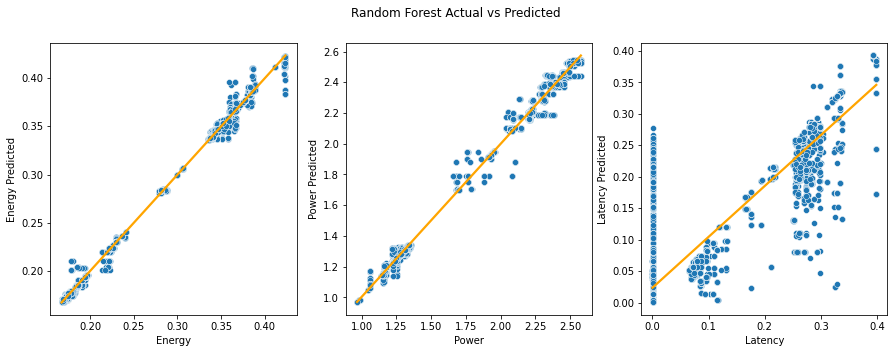

In [ ]:
# Random Forest Graph
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle("Random Forest Actual vs Predicted")
plt.subplot(1,3,1)
ax0 = sns.scatterplot(x='Energy', y='Energy Predicted', data=rf_evaluation_df)
sns.regplot(x='Energy', y='Energy Predicted',
            scatter=False, data=rf_evaluation_df,
            ax=ax0, color="orange")

plt.subplot(1,3,2)
ax1 = sns.scatterplot(x='Power', y='Power Predicted', data=rf_evaluation_df)
sns.regplot(x='Power', y='Power Predicted',
            scatter=False, data=rf_evaluation_df,
            ax=ax1, color="orange")

plt.subplot(1,3,3)
ax2 = sns.scatterplot(x='Latency', y='Latency Predicted', data=rf_evaluation_df)
sns.regplot(x='Latency', y='Latency Predicted',
            scatter=False, data=rf_evaluation_df,
            ax=ax2, color="orange")

# Random Forest Regression Single Target

Train 3 Models

*   Energy Random Forest Regression Model
*   Power Random Forest Regression Model
*   Latency Random Forest Regression Model



Search for Best Hyperparameters for **Energy** (This block takes a long time to execute.)

In [ ]:
rf= RandomForestRegressor(n_estimators=100,criterion='mse', 
                                 max_depth=10, min_samples_split=10,
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True, n_jobs=-1, random_state=100, verbose=0)


grid_rf_energy = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,scoring = 'neg_mean_squared_error',random_state =100)

grid_rf_energy.fit(X_train,y_train['Energy'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(criterion='mse',
                                                   max_depth=10,
                                                   min_samples_split=10,
                                                   n_jobs=-1,
                                                   random_state=100),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [20, 104, 188, 272, 357,
                                                         441, 525, 610, 694,
                                                         778, 862, 947, 1031,
       

Search for best hyperparameters for **Power** (This block takes a long time to execute.)

In [ ]:
rf= RandomForestRegressor(n_estimators=100,criterion='mse', 
                                 max_depth=10, min_samples_split=10,
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True, n_jobs=-1, random_state=100, verbose=0)


grid_rf_power = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,scoring = 'neg_mean_squared_error',random_state =100)

grid_rf_power.fit(X_train,y_train['Power'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(criterion='mse',
                                                   max_depth=10,
                                                   min_samples_split=10,
                                                   n_jobs=-1,
                                                   random_state=100),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [20, 104, 188, 272, 357,
                                                         441, 525, 610, 694,
                                                         778, 862, 947, 1031,
       

Search for Best Hyperparameters for **Latency** (This block takes a long time to execute.)

In [ ]:
rf= RandomForestRegressor(n_estimators=100,criterion='mse', 
                                 max_depth=10, min_samples_split=10,
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True, n_jobs=-1, random_state=100, verbose=0)


grid_rf_latency = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,scoring = 'neg_mean_squared_error',random_state =100)

grid_rf_latency.fit(X_train,y_train['Latency'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(criterion='mse',
                                                   max_depth=10,
                                                   min_samples_split=10,
                                                   n_jobs=-1,
                                                   random_state=100),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [20, 104, 188, 272, 357,
                                                         441, 525, 610, 694,
                                                         778, 862, 947, 1031,
       

In [ ]:
grid_rf_energy.best_params_

# {'n_estimators': 1200,
#  'min_samples_split': 15,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': 8}

{'n_estimators': 1200,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 8}

In [ ]:
grid_rf_power.best_params_

# {'n_estimators': 20,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 8}

{'n_estimators': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 8}

In [ ]:
grid_rf_latency.best_params_

# {'n_estimators': 610,
#  'min_samples_split': 5,
#  'min_samples_leaf': 5,
#  'max_features': 'auto',
#  'max_depth': 8}

{'n_estimators': 610,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 8}

Train Random Forest Model for **Energy**

In [36]:
rf_energy = RandomForestRegressor(n_estimators=1200,criterion='mse', 
                                 max_depth=8, min_samples_split=15,
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True,n_jobs=-1, random_state=100, verbose=0)
rf_energy.fit(X_train,y_train['Energy'])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', max_depth=8, min_samples_split=15,
                      n_estimators=1200, n_jobs=-1, random_state=100)

Train Random Forest Model for **Power**

In [37]:
rf_power = RandomForestRegressor(n_estimators=20,criterion='mse', 
                                 max_depth=8, min_samples_split=5,
                                 min_samples_leaf=2, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True,n_jobs=-1, random_state=100, verbose=0)
rf_power.fit(X_train,y_train['Power'])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', max_depth=8, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=20, n_jobs=-1,
                      random_state=100)

Train Random Forest Model for **Latency**

In [38]:
rf_latency = RandomForestRegressor(n_estimators=610,criterion='mse', 
                                 max_depth=8, min_samples_split=5,
                                 min_samples_leaf=5, min_weight_fraction_leaf=0.0,
                                 max_features='auto', bootstrap=True,n_jobs=-1, random_state=100, verbose=0)
rf_latency.fit(X_train,y_train['Latency'])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', max_depth=8, min_samples_leaf=5,
                      min_samples_split=5, n_estimators=610, n_jobs=-1,
                      random_state=100)

Evaluate RF **Energy** Model

In [39]:
# Prediction
y_train_pred_rf_energy = rf_energy.predict(X_train)
y_test_pred_rf_energy = rf_energy.predict(X_test)

#Scoring
print('Mean Squared Error for train : {}'.format(round(mse(y_train['Energy'],y_train_pred_rf_energy),5)))
print('Mean Squared Error for test : {}'.format(round(mse(y_test['Energy'],y_test_pred_rf_energy),5)))

Mean Squared Error for train : 1e-05
Mean Squared Error for test : 1e-05


Evaluate RL **Power** Model

In [40]:
# Prediction
y_train_pred_rf_power = rf_power.predict(X_train)
y_test_pred_rf_power = rf_power.predict(X_test)

#Scoring
print('Mean Squared Error for train : {}'.format(round(mse(y_train['Power'],y_train_pred_rf_power),5)))
print('Mean Squared Error for test : {}'.format(round(mse(y_test['Power'],y_test_pred_rf_power),5)))

Mean Squared Error for train : 0.00105
Mean Squared Error for test : 0.00106


Evaluate RL **Latency** Model

In [41]:
# Prediction
y_train_pred_rf_latency = rf_latency.predict(X_train)
y_test_pred_rf_latency = rf_latency.predict(X_test)

#Scoring
print('Mean Squared Error for train : {}'.format(round(mse(y_train['Latency'],y_train_pred_rf_latency),5)))
print('Mean Squared Error for test : {}'.format(round(mse(y_test['Latency'],y_test_pred_rf_latency),5)))

Mean Squared Error for train : 0.00229
Mean Squared Error for test : 0.00244


Visualize Error Distribution

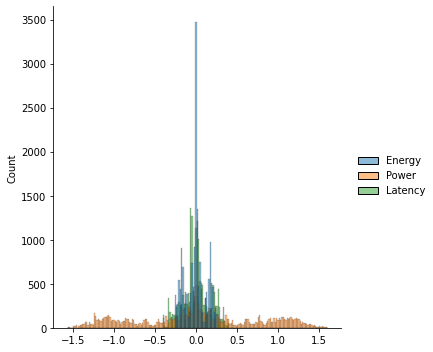

In [42]:
#Checking error distribution
y_test_pred_rf_error_distribution = {'Energy': y_train_pred_rf_energy, 
                              'Power': y_train_pred_rf_power, 
                              'Latency': y_train_pred_rf_latency}
y_test_pred_rf_error_distribution = pd.DataFrame(y_test_pred_rf_error_distribution)

sns.displot(y_test-y_test_pred_rf_error_distribution)

Visualize Single Target RF Models

In [46]:
rf_single_target_pred = {'Energy Predicted': y_test_pred_rf_energy, 
                              'Power Predicted': y_test_pred_rf_power, 
                              'Latency Predicted': y_test_pred_rf_latency}
rf_single_target_pred = pd.DataFrame(rf_single_target_pred)


rf_single_target_evaluation_df = y_test_index_reset.join(rf_single_target_pred)

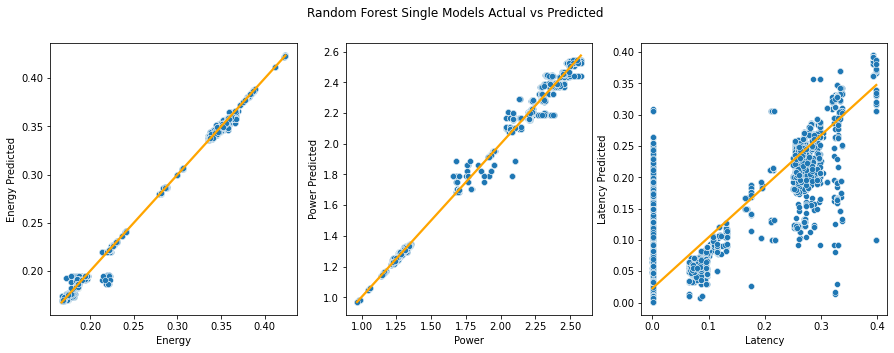

In [48]:
# Random Forest Graph
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle("Random Forest Single Models Actual vs Predicted")
plt.subplot(1,3,1)
ax0 = sns.scatterplot(x='Energy', y='Energy Predicted', data=rf_single_target_evaluation_df)
sns.regplot(x='Energy', y='Energy Predicted',
            scatter=False, data=rf_single_target_evaluation_df,
            ax=ax0, color="orange")

plt.subplot(1,3,2)
ax1 = sns.scatterplot(x='Power', y='Power Predicted', data=rf_single_target_evaluation_df)
sns.regplot(x='Power', y='Power Predicted',
            scatter=False, data=rf_single_target_evaluation_df,
            ax=ax1, color="orange")

plt.subplot(1,3,3)
ax2 = sns.scatterplot(x='Latency', y='Latency Predicted', data=rf_single_target_evaluation_df)
sns.regplot(x='Latency', y='Latency Predicted',
            scatter=False, data=rf_single_target_evaluation_df,
            ax=ax2, color="orange")

# Saving Models

In [53]:
PROXY_MODEL_DIRECTORY = 'proxy_models'
print(os.getcwd())

/content/arch-gym-proxy-models


In [ ]:
# Save Linear Regression Model
path = os.path.join(PROXY_MODEL_DIRECTORY, 'linear_regression_model')
pickle.dump(linear, open(path, 'wb'))

In [ ]:
# Save Multi-Target Random Forest Regression Model
path = os.path.join(PROXY_MODEL_DIRECTORY, 'multitarget_rf_model')
pickle.dump(rf, open(path, 'wb'))

In [54]:
# Save Single Target Random Forest Regression Models
# Energy
path = os.path.join(PROXY_MODEL_DIRECTORY, 'energy_rf_model')
pickle.dump(rf_energy, open(path, 'wb'))
# Power
path = os.path.join(PROXY_MODEL_DIRECTORY, 'power_rf_model')
pickle.dump(rf_power, open(path, 'wb'))
# Latency
path = os.path.join(PROXY_MODEL_DIRECTORY, 'latency_rf_model')
pickle.dump(rf_latency, open(path, 'wb'))